# **Analyse_Student_Population_Impact_On_Local_Business_Revenue**

**Authored by**: Shivani Satav

**Duration:** 90 mins

**Level:** Intermediate

**Pre-requisite Skills:** Python, Pandas, Matplotlib, Seaborn

**Scenario**

Local councils, educational institutions, and business chambers often need to understand how the presence of students—especially international students—affects the local economy. In many urban areas, student populations contribute significantly to demand for housing, retail, hospitality, and part-time jobs. This analysis scenario investigates whether there is a correlation between the number of students in different suburbs and local business performance (in terms of business count and employment opportunities).

By merging and analyzing the datasets, decision-makers can identify patterns, trends, and correlations to guide economic and urban planning strategies.

**User Story**

**As a** city economic development planner,
**I want to** analyze how student populations influence the number of businesses and jobs in local suburbs,
**So that** I can make informed policy decisions, plan infrastructure, and create initiatives to support both student communities and local businesses.

**Introduction**

The document aims to explore the relationship between student population size and local business economic indicators across different suburbs and years.

This analysis follows these main stages:

Data Collection – Importing datasets on student populations, residents' education attendance, and local business establishment details.

Data Cleaning & Preprocessing – Renaming columns, filtering relevant records, and aligning suburb names for consistency.

Exploratory Data Analysis (EDA) – Summarizing and visualizing student and business trends over time, identifying top student-concentrated suburbs.

Correlation Analysis – Merging datasets to calculate statistical relationships between student counts, business counts, and job counts.

Visual Analysis – Using line plots, bar charts, and scatter plots to present patterns and relationships in an easily interpretable way.

The outcome of this work can assist local governments, universities, and business networks in making data-driven decisions that maximize economic and social benefits from student populations

**Dataset Links**

Resident profiles with education attendance details https://data.melbourne.vic.gov.au/explore/dataset/residents-profiles-by-clue-small-area


Business establishments and job counts by suburb and industry: https://data.melbourne.vic.gov.au/explore/dataset/business-establishments-and-jobs-data-by-business-size-and-industry

**Importing Required Libraries**

We import essential Python libraries for data handling, analysis, and visualization:
- **pandas** and **numpy** for data manipulation and numerical operations.
- **matplotlib** and **seaborn** for creating visualizations.
Also configure a consistent style for our plots.

In [1]:
import requests
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual style
sns.set(style="whitegrid")

**Data Collection**

This section retrieves the datasets required to analyze the relationship between student populations
and local business activity using the City of Melbourne Open Data API.  

We define a reusable helper function `collect_data(dataset_id)` that:
1. Constructs the dataset export URL dynamically using the provided dataset ID.
2. Sends an HTTP GET request to the API with parameters to:
   - Select all available fields (`select: '*'`)
   - Retrieve all available records (`limit: -1`)
   - Standardize language (`lang: 'en'`) and timezone (`timezone: 'UTC'`)
3. If the request is successful:
   - Decodes the response from CSV format.
   - Loads the data into a Pandas DataFrame for further cleaning and analysis.
4. If the request fails:
   - Raises an exception with the returned HTTP status code.

Datasets Fetched:
- **Residents Profiles – Education Attendance**(`residents-profiles-by-clue-small-area`)  
  Contains information about residents attending educational institutions, broken down by suburb and year.
- **Business Establishments & Jobs** (`business-establishments-and-jobs-data-by-business-size-and-industry`)  
  Contains annual counts of businesses and jobs by suburb and industry classification.

These datasets form the foundation for correlating student counts with local business metrics.


In [36]:
def collect_data(datasetid):
    base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
    format = 'csv'
    url = f'{base_url}{datasetid}/exports/{format}'

    params = {
        'select': '*',
        'limit': -1,
        'lang': 'en',
        'timezone': 'UTC'
    }

    response = requests.get(url, params=params)
    if response.status_code == 200:
        csv_content = response.content.decode('utf-8')
        dataset = pd.read_csv(StringIO(csv_content), delimiter=';')
        return dataset
    else:
        raise Exception(f"Failed request {response.status_code} for {datasetid}")


# Fetch datasets

students_id = 'residents-profiles-by-clue-small-area'  # contains education attendance
business_id = 'business-establishments-and-jobs-data-by-business-size-and-industry'

students_df = collect_data(students_id)
business_df = collect_data(business_id)

print(f"Students dataset: {students_df.shape[0]} rows")
print(students_df.head(5))
print(f"Business dataset: {business_df.shape[0]} rows")
print(business_df.head(5))

Students dataset: 10776 rows
           geography  year                  topic                  category  \
0          Docklands  2011  Households: Dwellings  Dwelling type - detailed   
1     East Melbourne  2011  Households: Dwellings  Dwelling type - detailed   
2  Greater Melbourne  2011  Households: Dwellings  Dwelling type - detailed   
3    Melbourne (CBD)  2011  Households: Dwellings  Dwelling type - detailed   
4          Parkville  2011  Households: Dwellings  Dwelling type - detailed   

                                        sub_category  \
0        Flat or apartment - In a three storey block   
1  Semi-detached, row or terrace house, townhouse...   
2            Flat or apartment - Attached to a house   
3       Other dwelling - Caravan, cabin or houseboat   
4                      Dwelling structure not stated   

                     value_description   value  
0  Count of occupied private dwellings     0.0  
1  Count of occupied private dwellings   118.0  
2  Count of 

**Data Cleaning & Preprocessing**

This section prepares the raw student and business datasets for analysis by standardizing column names, filtering relevant records, handling missing values, and aggregating data where necessary.

1. Students Dataset (students_df)

* Rename Columns for clarity

* Filter Education-Related Attendance:
Only rows where category equals "Education Institution Attendance" and sub_category equals "Attending" are retained.

* Standardize Suburb Names:
Whitespace is removed and names are title-cased to ensure consistency.

* Convert Numeric Fields and Handle Nulls:

* Year and Student Count are converted to numeric types.

* Rows missing critical values (Year, Suburb, or Student Count) are dropped.

* Remaining missing Student Count values are filled with 0.

2. Business Dataset (business_df)
* Rename Columns to standard names

* Aggregate by Year and Suburb:
Sum the number of businesses (Business Count) and total jobs (Jobs) for each suburb and year.

* Standardize Suburb Names:
Remove extra whitespace and parentheses, and title-case names for consistency.

* Convert Numeric Fields and Handle Nulls:

* Convert Year, Business Count, and Jobs to numeric types.

* Drop rows missing critical values (Year, Suburb, or Business Count).

* Fill missing Jobs values with 0.

The cleaned datasets are now consistent, numeric fields are properly formatted, and missing or inconsistent data is handled, making them ready for merging and analysis

In [39]:
# =============================
# 1. Clean and Prepare Students Data
# =============================
# Rename columns
students_df.rename(columns={
    'geography': 'Suburb',
    'year': 'Year',
    'value': 'Student Count'
}, inplace=True)

# Filter only education-related attendance data
edu_students = students_df[
    (students_df['category'].str.lower() == 'education institution attendance') &
    (students_df['sub_category'].str.lower() == 'attending')
].copy()

# Standardize suburb names
edu_students['Suburb'] = edu_students['Suburb'].str.title().str.strip()

# Convert numeric fields and handle nulls
edu_students['Year'] = pd.to_numeric(edu_students['Year'], errors='coerce').astype('Int64')
edu_students['Student Count'] = pd.to_numeric(edu_students['Student Count'], errors='coerce')

# Drop rows with missing critical values
edu_students.dropna(subset=['Year', 'Suburb', 'Student Count'], inplace=True)

# Fill any remaining missing student counts with 0
edu_students['Student Count'] = edu_students['Student Count'].fillna(0)

# Aggregate student data by suburb and year
students_agg = edu_students.groupby(['Year', 'Suburb'])['Student Count'].sum().reset_index()


# =============================
# 2. Clean and Prepare Business Data
# =============================
# Rename columns
business_df.rename(columns={
    "census_year": "Year",
    "clue_small_area": "Suburb",
    "anzsic_indusrty": "ANZSIC Industry",
    "clue_industry": "CLUE Industry",
    "business_size": "Business Size",
    "total_establishments": "Business Count",
    "total_jobs": "Jobs"
}, inplace=True)

# Aggregate by Year and Suburb
business_agg = business_df.groupby(['Year', 'Suburb']).agg({
    'Business Count': 'sum',
    'Jobs': 'sum'
}).reset_index()

# Standardize suburb names
business_agg['Suburb'] = business_agg['Suburb'].str.strip().str.replace(r'\s*\(.*?\)', '', regex=True).str.title()
students_agg['Suburb'] = students_agg['Suburb'].str.strip().str.replace(r'\s*\(.*?\)', '', regex=True).str.title()

# Convert numeric fields and handle nulls
business_agg['Year'] = pd.to_numeric(business_agg['Year'], errors='coerce').astype('Int64')
business_agg['Business Count'] = pd.to_numeric(business_agg['Business Count'], errors='coerce')
business_agg['Jobs'] = pd.to_numeric(business_agg['Jobs'], errors='coerce')

# Drop rows with missing critical values
business_agg.dropna(subset=['Year', 'Suburb', 'Business Count'], inplace=True)

# Fill missing jobs with 0
business_agg['Jobs'] = business_agg['Jobs'].fillna(0)



**Data Merging and Correlation Analysis**

This code block performs the following key tasks:

1. Merge Datasets to combine the aggregated student and business data into a single dataframe (merged_df) on Year and Suburb.This allows for joint analysis of student attendance and business activity.

5. Ensure numeric columns are correct by converting Student Count, Business Count, and Jobs to numeric types, handling any non-numeric or missing values.

6. Correlation Analysis: Computes the correlation between Student Count, Business Count, and Jobs.
This helps identify potential relationships or dependencies between student presence and business activity in different suburbs

In [40]:
merged_df = pd.merge(students_agg, business_agg, on=['Year', 'Suburb'])

# Merge for heatmap (aggregate by Suburb)
student_business = pd.merge(
    edu_students.groupby('Suburb')['Student Count'].sum().reset_index(),
    business_agg.groupby('Suburb')[['Business Count', 'Jobs']].sum().reset_index(),
    on='Suburb'
)

# Ensure numeric columns are correct
merged_df['Student Count'] = pd.to_numeric(merged_df['Student Count'], errors='coerce')
merged_df['Business Count'] = pd.to_numeric(merged_df['Business Count'], errors='coerce')
merged_df['Jobs'] = pd.to_numeric(merged_df['Jobs'], errors='coerce')


# =============================
# 4. Correlation Analysis
# =============================
corr = merged_df[['Student Count', 'Business Count', 'Jobs']].corr()
print("Correlation between Student Count, Business Count, and Jobs:")
print(corr)


Correlation between Student Count, Business Count, and Jobs:
                Student Count  Business Count      Jobs
Student Count        1.000000        0.906047  0.904976
Business Count       0.906047        1.000000  0.998643
Jobs                 0.904976        0.998643  1.000000


**Exploratory Data Analysis (EDA)**

This code block performs EDA to understand the student and business datasets:

Displays summary statistics for numerical columns (Student Count, Business Count, Jobs) using describe() to identify key metrics like mean, median, and range.

Plots the distribution of Student Count using a histogram with a kernel density estimate (KDE) to visualise student population trends across suburbs.

Creates bar charts to show the top 10 suburbs by student count and the top 10 industries by business count to identify areas or sectors with high activity.

Generates a heatmap of Student Count, Business Count, and Jobs across suburbs to visualise patterns and potential correlations.

Students Dataset Summary:
count    2.400000e+01
mean     9.321054e+04
std      2.933031e+05
min      7.050000e+02
25%      1.387750e+03
50%      3.194500e+03
75%      7.911750e+03
max      1.118744e+06
Name: Student Count, dtype: float64

Business Dataset Summary:
       Business Count          Jobs
count      308.000000  3.080000e+02
mean      3224.113636  8.757658e+04
std       7789.865994  2.192196e+05
min         52.000000  1.950000e+02
25%        365.000000  4.873000e+03
50%        505.500000  1.363700e+04
75%       1031.000000  2.981000e+04
max      33536.000000  1.025077e+06


/tmp/ipython-input-3894283360.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_students.values, y=top_students.index, palette='viridis')


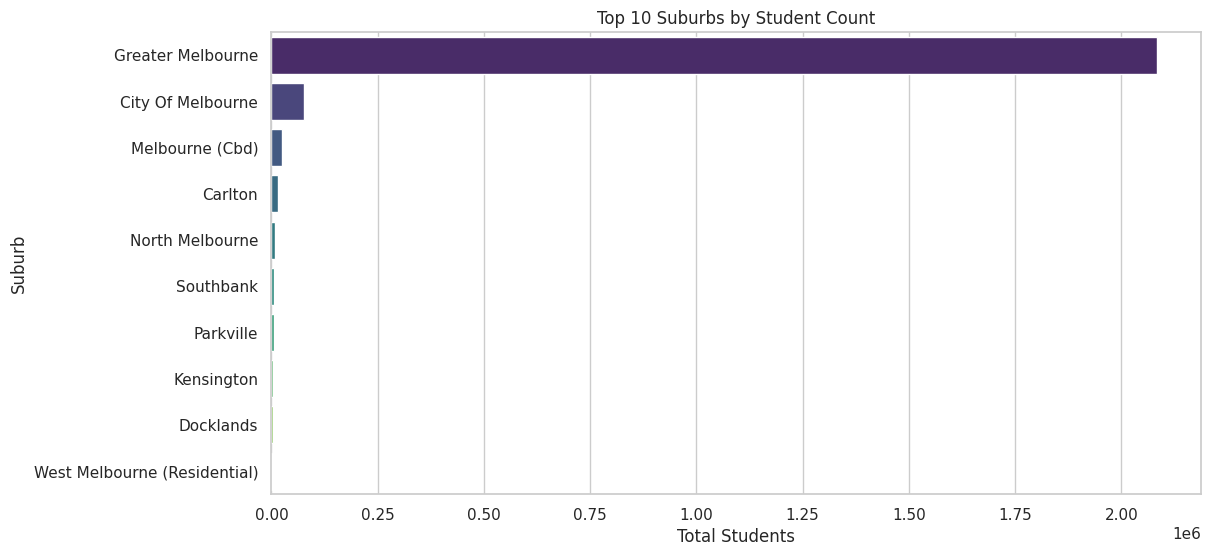

/tmp/ipython-input-3894283360.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_industries.values, y=top_industries.index, palette='magma')


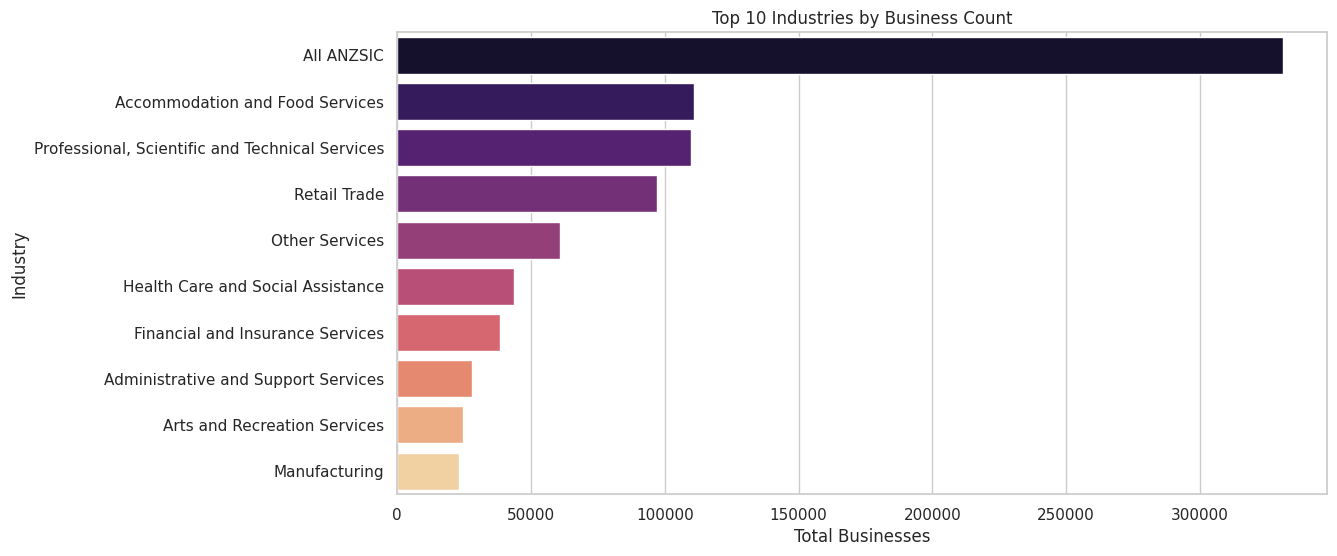

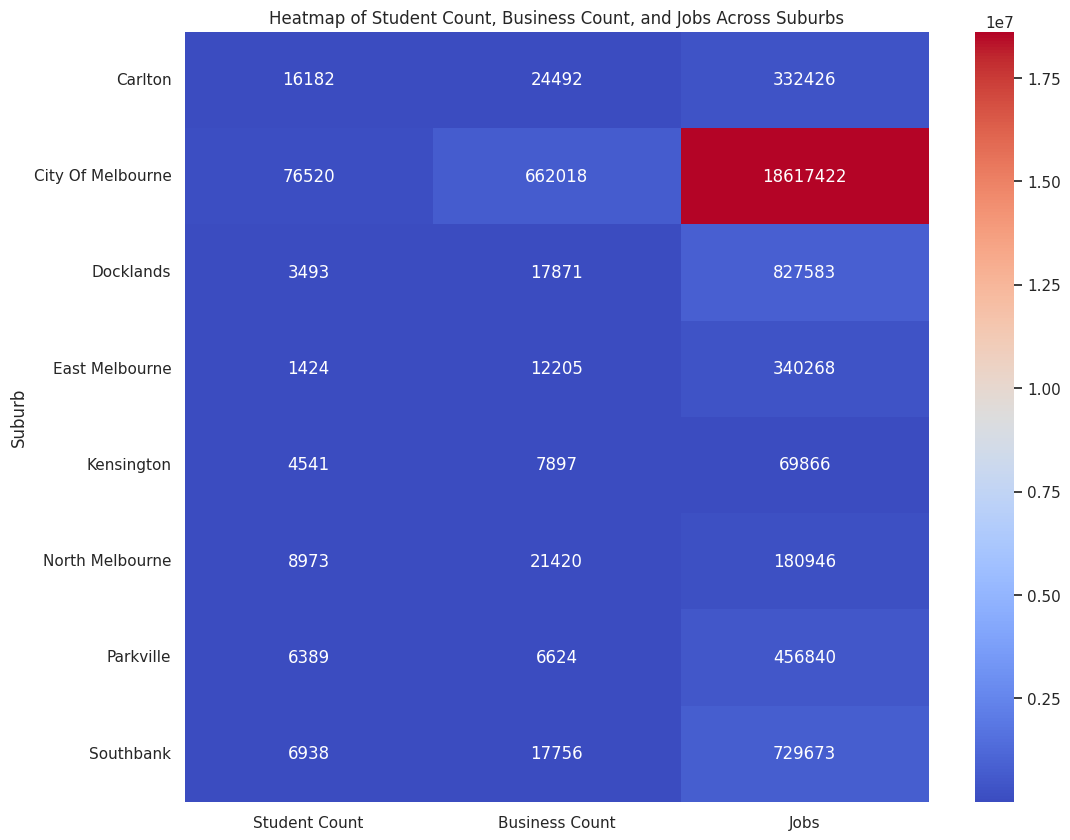

In [47]:
# 1. Summary Statistics
print("Students Dataset Summary:")
print(edu_students['Student Count'].describe())

print("\nBusiness Dataset Summary:")
print(business_agg[['Business Count', 'Jobs']].describe())

# 1. Top Suburbs by Student Count
top_students = edu_students.groupby('Suburb')['Student Count'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12,6))
sns.barplot(x=top_students.values, y=top_students.index, palette='viridis')
plt.title("Top 10 Suburbs by Student Count")
plt.xlabel("Total Students")
plt.ylabel("Suburb")
plt.show()

# 2. Top Industries by Business Count
top_industries = business_df.groupby('ANZSIC Industry')['Business Count'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12,6))
sns.barplot(x=top_industries.values, y=top_industries.index, palette='magma')
plt.title("Top 10 Industries by Business Count")
plt.xlabel("Total Businesses")
plt.ylabel("Industry")
plt.show()

# 3. Heatmap of Students, Businesses, Jobs
heatmap_data = student_business.set_index('Suburb')
plt.figure(figsize=(12,10))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap='coolwarm')
plt.title("Heatmap of Student Count, Business Count, and Jobs Across Suburbs")
plt.show()

**Insights from Exploratory Data Analysis (EDA)**

The exploratory data analysis revealed the following key insights:

**Student Count Distribution:**

The histogram of student counts shows the distribution across suburbs, highlighting suburbs with high and low student populations.

This insight helps identify areas with larger student communities, which could be relevant for educational planning or service provision.

**Top Suburbs and Industries:**

The bar charts show which suburbs have the highest student numbers and which industries have the most businesses.

High student population suburbs may coincide with high business activity in certain sectors, suggesting potential hotspots of social and economic activity.

**Correlation Patterns:**

The heatmap reveals how student counts, business counts, and jobs are distributed across suburbs.

Areas with both high student populations and high business activity may indicate vibrant neighborhoods with economic and social interactions.

These insights provide a foundational understanding of the datasets, helping to identify trends, anomalies, and potential areas for further analysis

**Trend Analysis: Students vs Businesses Over Years**

This code block visualizes trends in student population, business establishments, and job counts over the years:

Aggregates data by year to get the total student count, business count, and jobs.

Line plots show how these metrics evolve over time.

The visualization provides a quick overview of growth patterns and potential correlations between education and business activity.


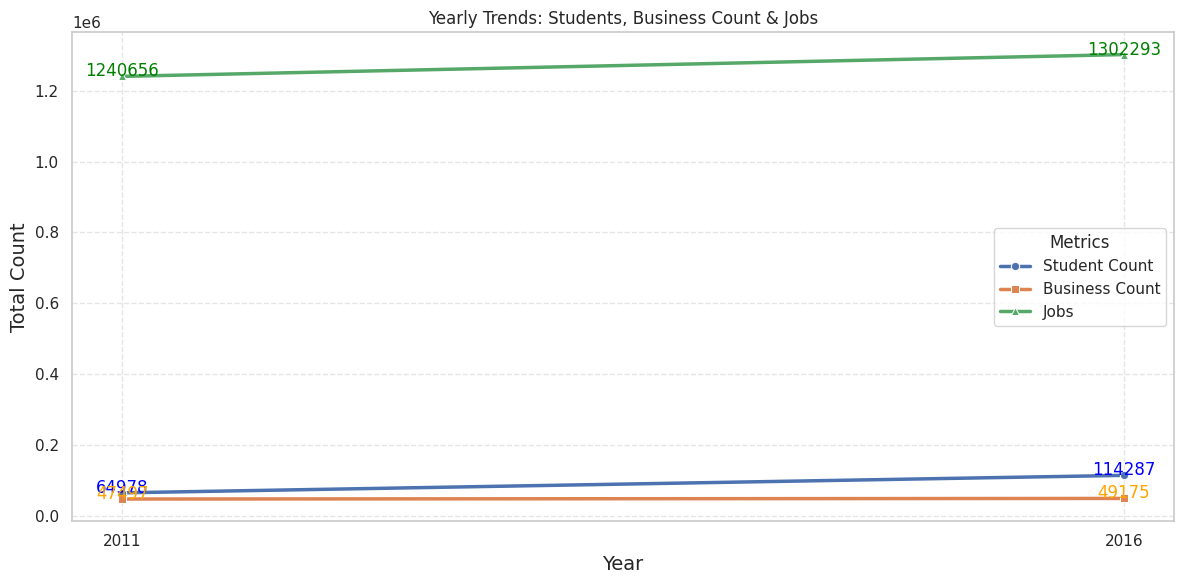

In [55]:
# Plot each line with distinct styles
sns.lineplot(data=yearly_trends, x='Year', y='Student Count', label='Student Count', marker='o', linewidth=2.5)
sns.lineplot(data=yearly_trends, x='Year', y='Business Count', label='Business Count', marker='s', linewidth=2.5)
sns.lineplot(data=yearly_trends, x='Year', y='Jobs', label='Jobs', marker='^', linewidth=2.5)

# Add data labels for each year
for i, row in yearly_trends.iterrows():
    plt.text(row['Year'], row['Student Count'] + 50, int(row['Student Count']), color='blue', ha='center')
    plt.text(row['Year'], row['Business Count'] + 50, int(row['Business Count']), color='orange', ha='center')
    plt.text(row['Year'], row['Jobs'] + 50, int(row['Jobs']), color='green', ha='center')

# Titles and labels
plt.title('Yearly Trends: Students, Business Count & Jobs')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Total Count', fontsize=14)

# Grid and legend
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(yearly_trends['Year'].unique())
plt.legend(title='Metrics')

plt.tight_layout()
plt.show()




**Insights from the Trend Analysis:**
1. Student Count Trends

The line for student counts shows whether the number of students is increasing, decreasing, or stable over the years.

Identifies periods of growth or decline in the student population.

2. Business Count Trends

The business count line indicates changes in the number of active businesses over time.

Highlights periods of economic growth or slowdown in the suburbs.

3. Jobs Trends

The jobs line reflects employment levels across all suburbs.

Comparison with business counts can indicate productivity or business-to-job ratios.

Overall Patterns

By comparing all three lines, we can assess if student population growth aligns with business and employment growth.

Potential correlations may indicate that areas with growing student populations also experience economic development.

 **Jobs vs Student Count**

This visualization explores the relationship between student populations, jobs, and businesses across different suburbs:

X-axis: Student Count – represents the total number of students in a suburb.

Y-axis: Jobs – total number of jobs available in the suburb.

Bubble size: Business Count – larger bubbles indicate suburbs with more businesses.

Hue: Suburb – each suburb is assigned a distinct color for comparison.



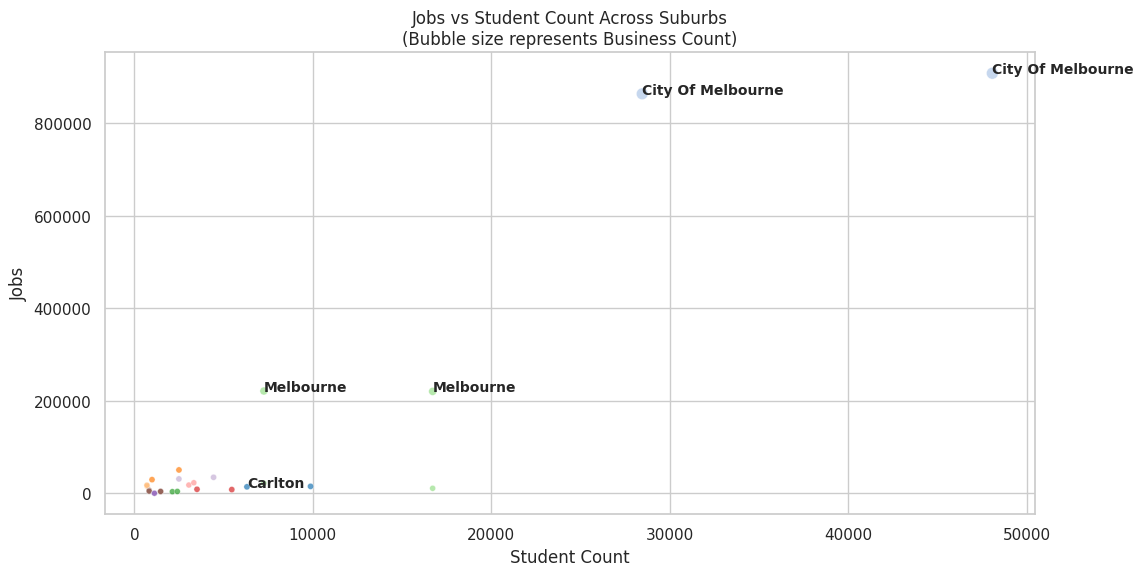

In [53]:
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=merged_df,
    x='Student Count',
    y='Jobs',
    size='Business Count',
    hue='Suburb',
    palette='tab20',
    alpha=0.7,
    legend=False
)
plt.title('Jobs vs Student Count Across Suburbs\n(Bubble size represents Business Count)')
plt.xlabel('Student Count')
plt.ylabel('Jobs')


top_suburbs = merged_df.nlargest(5, 'Business Count')
for _, row in top_suburbs.iterrows():
    plt.text(
        row['Student Count'] + 5,
        row['Jobs'] + 5,
        row['Suburb'],
        fontsize=10,
        weight='bold'
    )
plt.show()


**Insights from the Bubble Chart:**

Correlation:
Suburbs with higher student counts often have more jobs, suggesting that educational institutions may influence local employment.

Business Impact:
Larger bubbles highlight suburbs where the number of businesses is significant, indicating a stronger economic activity.

Outliers and Trends:
Suburbs with disproportionately high jobs but low student populations (or vice versa) stand out, which could indicate specialized economic zones or areas with a high influx of workers.

Strategic Insights:
This visualization can guide policymakers or investors to identify areas with growing student populations and business activity, helping target education or business-related initiatives effectively.